In [2]:

import numpy as np

from lmfit import Parameters, Minimizer, fit_report, conf_interval, report_ci
import matplotlib.pyplot as plt



def volume_fcn2(T, a0, a1, a2, a3, a4, a5, a6, a7, a8):
    x = T/1000
    return a0*np.exp( a1*a2/(np.exp(a2/x)-1)
                     +a3*a4/(np.exp(a4/x)-1)
                     +a5*a6/(np.exp(a6/x)-1)
                     +a7*a8/(np.exp(a8/x)-1))

def CET_fcn2(T, a0, a1, a2, a3, a4, a5, a6, a7, a8):
    x = T/1000
    CTE =   (((a1*a2**2.0*np.exp(a2/x))/((x**2.0)*(np.exp(a2/x)-1)**2.0))
            +((a3*a4**2.0*np.exp(a4/x))/((x**2.0)*(np.exp(a4/x)-1)**2.0))
            +((a5*a6**2.0*np.exp(a6/x))/((x**2.0)*(np.exp(a6/x)-1)**2.0))
            +((a7*a8**2.0*np.exp(a8/x))/((x**2.0)*(np.exp(a8/x)-1)**2.0))
           )/1000
    return CTE

def CET_numerical(T,V):
    #linear extrapolation of volume at T=0
    v0 = V[0]-((V[1]-V[0])/(T[1]-T[0]))*T[0]
    T = np.insert(T, 0, 0.0)
    V = np.insert(V, 0, v0)
    CET = [0.0]
    for i in range(1,len(T)):
        CET.append((1.0/V[i])*(V[i]-V[i-1])/(T[i]-T[i-1]))
    return np.array(CET[1:])

def func2min2(params, T, V, CET):
    parametros = [params[k] for k in params.keys()]
    model_vol = volume_fcn2(T, *parametros)
    residual_vol = model_vol - V  
    return residual_vol

def fit_volume_vs_temperature2(T, V, CET, verbose=True):
    params = Parameters()
    params.add('a0', value=7000, min=0, max=9000, vary=True)
    params.add('a1', value=0.1, min=-50, max=50, vary=True)
    params.add('a2', value=0.01, min=0.001,max=3.5, vary=True)
    params.add('a3', value=0.1, min=-50, max=50, vary=True)
    params.add('a4', value=0.1, min=0.001,max=3.5, vary=True)
    params.add('a5', value=0., min=-100, max=100,vary=False)
    params.add('a6', value=1., min=0.001,max=3.5,vary=False)
    params.add('a7', value=0., min=-100, max=100,vary=False)
    params.add('a8', value=1., min=0.001,max=3.5,vary=False)
  
    minimizer = Minimizer(func2min2, params, fcn_args=(T, V, CET))
    fit_kws = {'totaliter': 30,
               'maxiter': 6,
               'local': 'L-BFGS-B',
               'tabulistsize': 8,}
    out = minimizer.minimize(method='ampgo')#, **kws) 
    fit = func2min2(out.params, T, V,CET)
    if verbose:
        print(fit_report(out), flush=True)
        print('Cost:',np.sum(fit))
        print('---------- DE bounds ----------')
        for k in out.params.keys():
            print('{0:3}:  {1: >8}\t{2: >12.6g}\t{3: >8}'.format(k,out.params[k].min,out.params[k].value,out.params[k].max))
        
    return out

def second_fit2(T,V,CET,out, verbose=True):
    minimizer = Minimizer(func2min2, out.params, fcn_args=(T, V, CET))
    result2 = minimizer.minimize(method='nelder')
    if verbose:
        print(fit_report(result2), flush=True)
    return result2

def plot2(x_data, y_data, x_fit, y_fit, z_data, z_fit, file):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,dpi=120,figsize=(10,3))
    ax1.plot(x_data, y_data, 'o', label='data')
    ax1.plot(x_fit, y_fit, '-',label='fit')
    ax1.set_ylabel('Volume (A3)')
    ax1.set_xlabel('Temperature (K)')
    ax1.legend()
    
    ax2.plot(x_data, 1e6*z_data, 'x',label='Data')
    ax2.plot(x_fit, 1e6*z_fit, label='Fit')
    ax2.set_xlabel('Temperature (K)')
    ax2.set_ylabel('Volumetric thermal expansion\ncoefficient (K$^{-1}$)')
    ax2.legend()
    plt.suptitle(file)
    plt.savefig(file.rstrip('dat')+'pdf')
    plt.show()

######################### ./volume_vs_temperature.dat ##########################
Fitting 1
[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 20112
    # data points      = 30
    # variables        = 5
    chi-square         = 7.9943e-07
    reduced chi-square = 3.1977e-08
    Akaike info crit   = -513.216741
    Bayesian info crit = -506.210755
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  46.1960534 +/- 5.5245e-05 (0.00%) (init = 7000)
    a1:  8.0925e-05 +/-        nan (nan%) (init = 0.1)
    a2:  0.29695492 +/-        nan (nan%) (init = 0.01)
    a3:  0.00688760 +/- 3.6870e-04 (5.35%) (init = 0.1)
    a4:  0.96753794 +/- 0.02407910 (2.49%) (init = 0.1)
    a5:  0 (fixed)
    a6:  1 (fixed)
    a7:  0 (fixed)
    a8:  1 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a4) =  0.964


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: 9.66144796521462e-05
---------- DE bounds ----------
a0 :         0	     46.1961	    9000
a1 :       -50	 8.09253e-05	      50
a2 :     0.001	    0.296955	     3.5
a3 :       -50	   0.0068876	      50
a4 :     0.001	    0.967538	     3.5
a5 :      -100	           0	     100
a6 :     0.001	           1	     3.5
a7 :      -100	           0	     100
a8 :     0.001	           1	     3.5
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1453
    # data points      = 30
    # variables        = 5
    chi-square         = 2.2029e-09
    reduced chi-square = 8.8117e-11
    Akaike info crit   = -690.040253
    Bayesian info crit = -683.034266
##  Warning: uncertainties could not be estimated:
    a0:  at initial value
[[Variables]]
    a0:  46.1960550 +/- 2.8772e-06 (0.00%) (init = 46.19605)
    a1:  0.00101224 +/-        nan (nan%) (init = 8.092525e-05)
    a2:  0.54546355 +/-        nan (nan%) (init = 0.2969549)
    a3:  0.01425954 +/- 1.4887e-04 (1.04%) (

/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


    Better solution found. Cost:0.00023886486572877175
Good cost achieved. Stopping. Final cost: 0.00023886486572877175


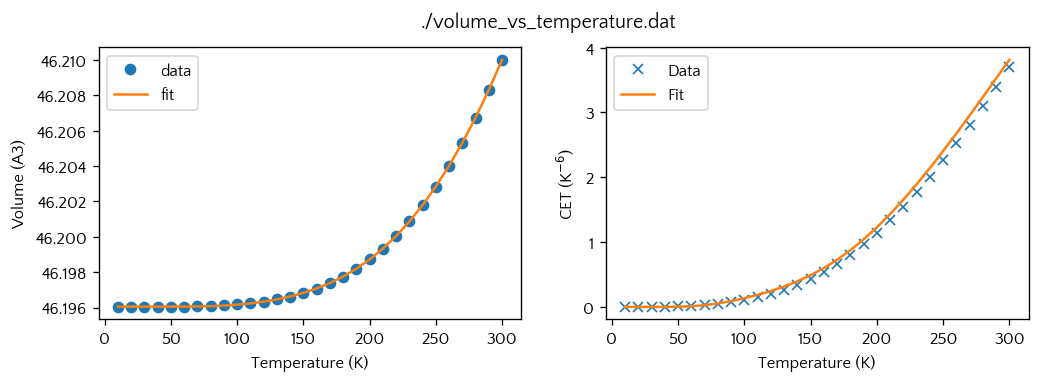

In [29]:

file = './volume_vs_temperature.dat'
print('{0:#^80}'.format(' '+str(file)+' '))
        
M = np.genfromtxt(file)
temperature = M[:,0]
volume = M[:,1]
cte_data = CET_numerical(temperature, volume)

#tenta varios fittings até obter um custo baixo ou atingir o maximo de iteracoes
max_nfits = 10
best_cost = np.inf
cost_threshold = 0.0011
cost = 1.0
for count in range(1,max_nfits+1):
    print(f'Fitting {count}')
    result0 = fit_volume_vs_temperature2(temperature, volume, cte_data, verbose=True)
    result = second_fit2(temperature, volume, cte_data, result0, verbose=True)
    params = [result.params[k].value for k in result.params.keys()]
    cost = np.sum(abs(func2min2(result.params, temperature, volume, cte_data)))
    if cost < best_cost:
        best_cost = cost
        best_params = list(params)
        print(f'    Better solution found. Cost:{cost}')
    if (cost<=cost_threshold):
        print(f'Good cost achieved. Stopping. Final cost: {cost}')
        break
        
if count == max_nfits:
    print(f'Max fittings achieved. Stopping and showing best result. Final cost:{cost}')
    
t_fit = np.array(temperature)
(a0, a1, a2, a3, a4, a5, a6, a7, a8) = (best_params)
v_nominal = volume_fcn2(t_fit,a0, a1, a2, a3, a4, a5, a6, a7, a8)
cte_nominal = CET_fcn2(t_fit,a0, a1, a2, a3, a4, a5, a6, a7, a8)
plot2(temperature, volume, t_fit, v_nominal, cte_data, cte_nominal, file)

v_unc = np.zeros(len(v_nominal))
cte_unc = np.zeros(len(v_nominal))       
with open(file.rstrip('dat')+'fit','w') as f:
    f.write('#{T:5}\t{V:10}\t{Vfit:10}\t{Vunc:10}\t{CET:10}\t{CETfit:10}\t{CETunc:10}\n'.format(T='T(K)',V='V(A3)',Vfit='Vfit(A3)',Vunc='Vunc(A3)',CET='CET(1/K)',CETfit='CETfit(1/K)',CETunc='CETunc(1/K)'))
    for i in range(len(temperature)):
        f.write('{T:5.1f}\t{V:10f}\t{Vfit:10f}\t{Vunc:10f}\t{CET: 10e}\t{CETfit: 10e}\t{CETunc: 10e}\n'.format(T=temperature[i],V=volume[i],Vfit=v_nominal[i],Vunc=v_unc[i],CET=cte_data[i],CETfit=cte_nominal[i],CETunc=cte_unc[i]))



__Backup: Great solution found. Cost:0.00023886486572877175___
```
######################### ./volume_vs_temperature.dat ##########################
Fitting 1
[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 20112
    # data points      = 30
    # variables        = 5
    chi-square         = 7.9943e-07
    reduced chi-square = 3.1977e-08
    Akaike info crit   = -513.216741
    Bayesian info crit = -506.210755
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  46.1960534 +/- 5.5245e-05 (0.00%) (init = 7000)
    a1:  8.0925e-05 +/-        nan (nan%) (init = 0.1)
    a2:  0.29695492 +/-        nan (nan%) (init = 0.01)
    a3:  0.00688760 +/- 3.6870e-04 (5.35%) (init = 0.1)
    a4:  0.96753794 +/- 0.02407910 (2.49%) (init = 0.1)
    a5:  0 (fixed)
    a6:  1 (fixed)
    a7:  0 (fixed)
    a8:  1 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a4) =  0.964

Cost: 9.66144796521462e-05
---------- DE bounds ----------
a0 :         0	     46.1961	    9000
a1 :       -50	 8.09253e-05	      50
a2 :     0.001	    0.296955	     3.5
a3 :       -50	   0.0068876	      50
a4 :     0.001	    0.967538	     3.5
a5 :      -100	           0	     100
a6 :     0.001	           1	     3.5
a7 :      -100	           0	     100
a8 :     0.001	           1	     3.5
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1453
    # data points      = 30
    # variables        = 5
    chi-square         = 2.2029e-09
    reduced chi-square = 8.8117e-11
    Akaike info crit   = -690.040253
    Bayesian info crit = -683.034266
##  Warning: uncertainties could not be estimated:
    a0:  at initial value
[[Variables]]
    a0:  46.1960550 +/- 2.8772e-06 (0.00%) (init = 46.19605)
    a1:  0.00101224 +/-        nan (nan%) (init = 8.092525e-05)
    a2:  0.54546355 +/-        nan (nan%) (init = 0.2969549)
    a3:  0.01425954 +/- 1.4887e-04 (1.04%) (init = 0.006887596)
    a4:  1.38914029 +/- 0.00368557 (0.27%) (init = 0.9675379)
    a5:  0 (fixed)
    a6:  1 (fixed)
    a7:  0 (fixed)
    a8:  1 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a4) =  1.092
    C(a0, a4) = -0.664
    C(a0, a3) = -0.395

    Better solution found. Cost:0.00023886486572877175
Good cost achieved. Stopping. Final cost: 0.00023886486572877175
```

# Paper figure

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def empirical_stoupin(T):
    b = 3.6e-14
    c = 1.21e-11
    T0 = 212
    DT0 = 47
    
    W = 1.0/(1+np.exp((T-T0)/DT0))
    x = b*W*T**3.0 + c*(1-W)*T**2.0
    
    return x

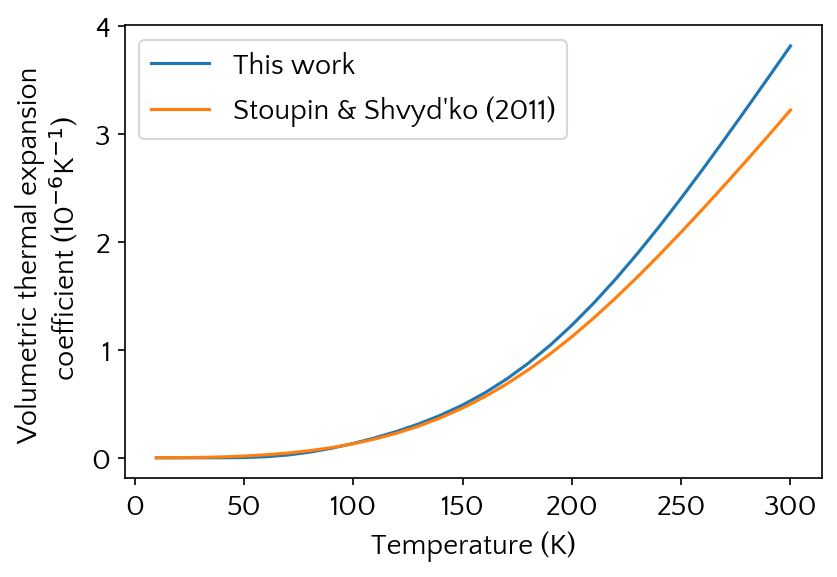

In [6]:

Tfit, alpha_md, alpha_fit = np.loadtxt('volume_vs_temperature.fit',usecols=(0,4,5), unpack=True)
alpha_exp = empirical_stoupin(Tfit)

plt.figure(dpi=150)
plt.rcParams['font.sans-serif']="Quattrocento Sans"
plt.rcParams['font.style']="normal"
plt.rcParams['font.size']=14

plt.plot(Tfit,1e6*alpha_fit,label='This work')
#plt.plot(Tfit,1e6*alpha_md,'x',label='This work')
plt.plot(Tfit,3e6*alpha_exp,label="Stoupin & Shvyd'ko (2011)")
plt.xlabel('Temperature (K)')
plt.ylabel('Volumetric thermal expansion \n coefficient (10$^{-6}$K$^{-1}$)')
plt.savefig('CET_100K_supercell_size2.pdf', bbox_inches='tight')
plt.legend()
plt.show()